In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBRegressor

import joblib

In [2]:
df_ml = pd.read_csv('../data/raw/df_ml.csv')
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321193 entries, 0 to 1321192
Data columns (total 93 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ID_partida           1321193 non-null  int64  
 1   jugada_num           1321193 non-null  int64  
 2   SAN                  1321193 non-null  object 
 3   eval                 1316155 non-null  float64
 4   turno                1321193 non-null  object 
 5   Resultado            1321193 non-null  int64  
 6   White                1321193 non-null  object 
 7   Black                1321193 non-null  object 
 8   WhiteElo             1321193 non-null  int64  
 9   BlackElo             1321193 non-null  int64  
 10  ECO                  1321193 non-null  object 
 11  ECO_Family           1321193 non-null  object 
 12  TimeControl          1321193 non-null  object 
 13  Termination          1321193 non-null  object 
 14  calidad_jugada       1321193 non-null  object 
 15

In [3]:
# Había nulos, en eval_anterior era nulo porque corresponden a la primera jugada y entonces no había jugada anterior
# En eval lo rellenamos con 0 que es neutro
df_ml['eval_anterior'] = df_ml['eval_anterior'].fillna(0)
df_ml['eval'] = df_ml['eval'].fillna(0)

exclude_cols = [col for col in df_ml.columns if col.startswith('FEN_')]
exclude_cols += ['ID_partida', 'jugada_num', 'SAN', 'turno', 'White', 'Black', 'ECO', 'TimeControl','Termination',
                 'material_blancas', 'material_negras', 'turno.1', 'enroque_blancas', 'enroque_negras','jaque', 'mate', 'desconocida']

df_ml = df_ml.drop(exclude_cols, axis=1)

# Variables categóricas a convertir en dummies
categorical_cols = ['ECO_Family', 'calidad_jugada']

# Metodo para variables categóricas
df_model = pd.get_dummies(df_ml, columns=categorical_cols, drop_first=True)

## RF

In [4]:
X = df_model.drop(columns=['BlackElo'])
y = df_model['BlackElo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

rf = RandomForestRegressor(n_estimators=100,
                           max_depth=15,
                           random_state=11,
                           n_jobs=-1,
                           verbose=1)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print('Resultados RandomForest')
print('MAE RF:', mean_absolute_error(y_test, y_pred_rf))
print('R² RF:', r2_score(y_test, y_pred_rf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s


Resultados RandomForest
MAE RF: 80.98114340856058
R² RF: 0.7137673684729857


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.1s finished


## Gridsearch RF

In [5]:
X = df_model.drop(columns=['BlackElo'])
y = df_model['BlackElo']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# HAcemos uuna muestra más pequeña para agilizar las pruebas
X_train_sample = X_train[:20000]  
y_train_sample = y_train[:20000]

rf = RandomForestRegressor(random_state=11, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5]}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=3,
                           verbose=3,
                           n_jobs=-1)

# Entrenamiento rápido con sample, si se quiere hacer sobre el total del DF tarda unas 4h
grid_search.fit(X_train_sample, y_train_sample)

best_rf = grid_search.best_estimator_
print('Mejores parámetros:', grid_search.best_params_)

y_pred = best_rf.predict(X_test)
print('Resultados GridSearch RandomForest')
print('MAE RF GridSearch:', mean_absolute_error(y_test, y_pred))
print('R² RF GridSearch:', r2_score(y_test, y_pred))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Resultados GridSearch RandomForest
MAE RF GridSearch: 108.83854551966013
R² RF GridSearch: 0.5127454668044916


In [6]:
# Cuando tenga los mjores parametros para la muestra  los pasoal entrenamiento completo.
best_rf.fit(X_train, y_train)

y_pred_final = best_rf.predict(X_test)

print('Resultados FINAL RandomForest')
print('MAE RF final:', mean_absolute_error(y_test, y_pred_final))
print('R² RF final:', r2_score(y_test, y_pred_final))


Resultados FINAL RandomForest
MAE RF final: 36.40594664956339
R² RF final: 0.9192700600762854


# Random Forest con Undersampling

In [21]:
X = df_model.drop(columns=['BlackElo'])
y = df_model['BlackElo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


X_train_sample = X_train.sample(n=40000, random_state=11)
y_train_sample = y_train.loc[X_train_sample.index]


rf = RandomForestRegressor(random_state=11, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=3,
                           verbose=3,
                           n_jobs=-1)

grid_search.fit(X_train_sample, y_train_sample)

best_rf_undersampling = grid_search.best_estimator_
print('Mejores parámetros:', grid_search.best_params_)

y_pred = best_rf_undersampling.predict(X_test)
print('Resultados GridSearch RandomForest')
print('MAE RF GridSearch:', mean_absolute_error(y_test, y_pred))
print('R² RF GridSearch:', r2_score(y_test, y_pred))


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Mejores parámetros: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Resultados GridSearch RandomForest
MAE RF GridSearch: 91.89875341451514
R² RF GridSearch: 0.6380038988401358


In [22]:
# Cuando tenga los mjores parametros para la muestra  los pasoal entrenamiento completo.
best_rf_undersampling.fit(X_train, y_train)

y_pred_final = best_rf_undersampling.predict(X_test)

print('Resultados FINAL RandomForest')
print('MAE RF final:', mean_absolute_error(y_test, y_pred_final))
print('R² RF final:', r2_score(y_test, y_pred_final))


Resultados FINAL RandomForest
MAE RF final: 36.40594664956339
R² RF final: 0.9192700600762854


In [23]:
joblib.dump(best_rf_undersampling, 'modelo_rf_93.joblib')

['modelo_rf_93.joblib']

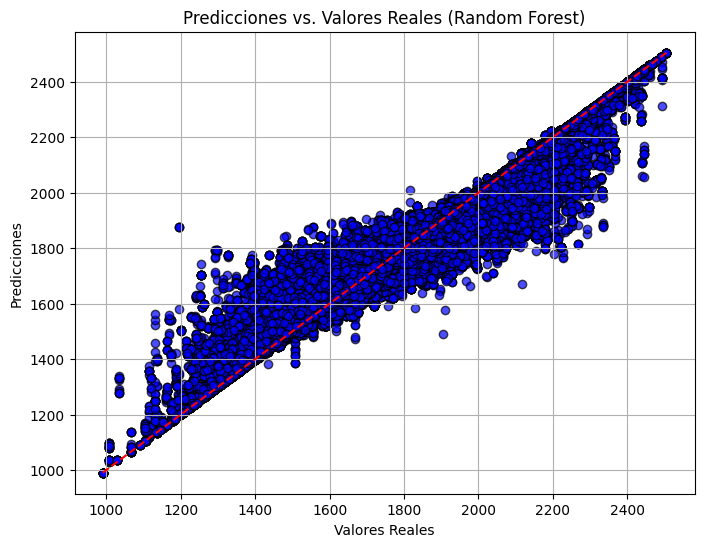

In [27]:
import matplotlib.pyplot as plt

# Suponiendo que tienes 'y_test' y 'y_pred_rf' para el modelo RF
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final, color='blue', edgecolors='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea diagonal
plt.title('Predicciones vs. Valores Reales (Random Forest)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()


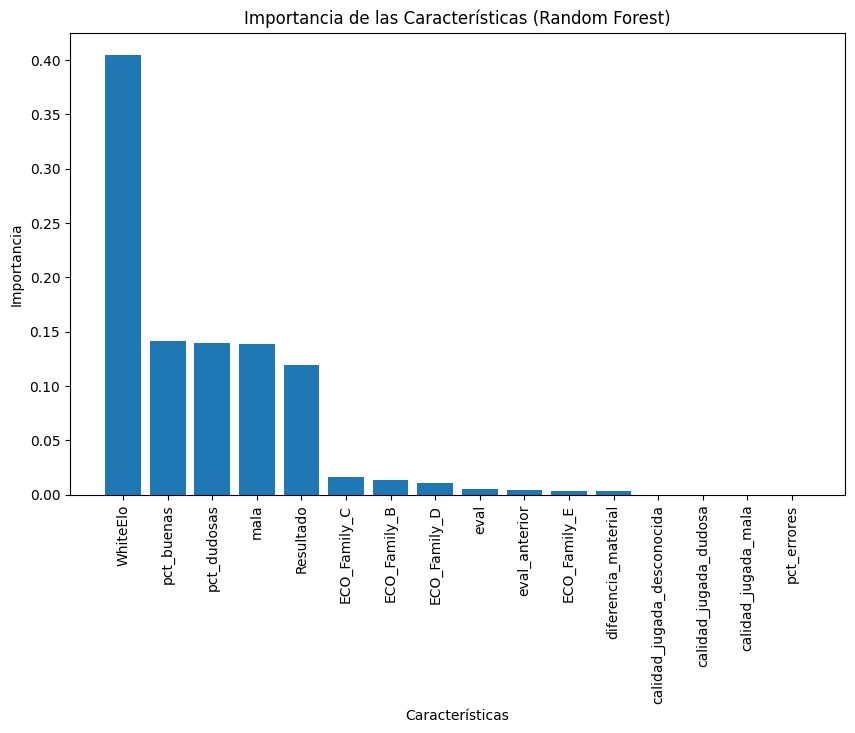

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que tienes un DataFrame con las características en 'X_train' y el modelo RF entrenado en 'model_rf'
# Si tus características están en un DataFrame llamado 'X_train', puedes obtener los nombres de las columnas.

# Obtener los nombres de las características
feature_names = X_train.columns

# Obtener la importancia de las características
importances_rf = best_rf_undersampling.feature_importances_

# Ordenar las características por importancia
indices_rf = np.argsort(importances_rf)[::-1]

# Graficar
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], align='center')
plt.xticks(range(len(importances_rf)), feature_names[indices_rf], rotation=90)  # Usar los nombres reales de las características
plt.title('Importancia de las Características (Random Forest)')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.show()


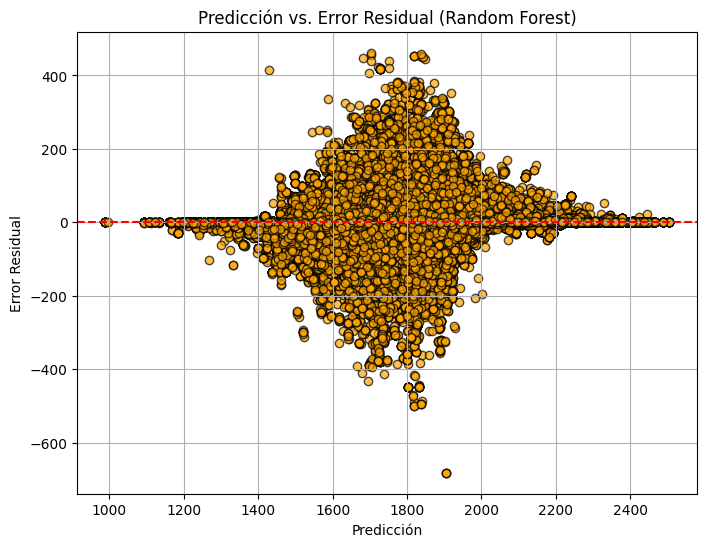

In [30]:
# Calcular residuos para RF
residuos_rf = y_test - y_pred_final

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf, residuos_rf, color='orange', edgecolors='k', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para referencia
plt.title('Predicción vs. Error Residual (Random Forest)')
plt.xlabel('Predicción')
plt.ylabel('Error Residual')
plt.grid(True)
plt.show()


## XGBOOST

In [10]:
X = df_model.drop(columns=['BlackElo'])
y = df_model['BlackElo']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a DMatrix de XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Configuración de los parámetros de XGBoost para regresión
params = {
    'objective': 'reg:squarederror',  # Para regresión (error cuadrático medio)
    'eval_metric': 'rmse',  # Error cuadrático medio (root mean squared error)
    'max_depth': 6,
    'eta': 0.1,  # Tasa de aprendizaje
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Entrenamiento del modelo
bst = xgb.train(params, dtrain, num_boost_round=100)

# Predicciones
y_pred = bst.predict(dtest)


print('Resultados FINAL XGBoost')
print('MAE XGboost final:', mean_absolute_error(y_test, y_pred))
print('R² XGboost final:', r2_score(y_test, y_pred))


Resultados FINAL XGBoost
MAE XGboost final: 121.91339874267578
R² XGboost final: 0.4238687753677368


In [33]:

X = df_model.drop(columns=['BlackElo'])
y = df_model['BlackElo']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


# HAcemos uuna muestra más pequeña para agilizar las pruebas
X_train_sample = X_train[:20000]  
y_train_sample = y_train[:20000]

xgb_model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=11)

param_grid = {
    'max_depth': [3, 6, 10],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'n_estimators': [50, 100, 200]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train_sample, y_train_sample)

print("Mejores parámetros:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print('Resultados FINAL XGBoost')
print('MAE XGboost final:', mean_absolute_error(y_test, y_pred))
print('R² XGboost final:', r2_score(y_test, y_pred))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Mejores parámetros: {'colsample_bytree': 0.9, 'eta': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.9}
Resultados FINAL XGBoost
MAE XGboost final: 106.17880249023438
R² XGboost final: 0.5250319242477417


In [34]:
# Cuando tenga los mjores parametros para la muestra  los pasoal entrenamiento completo.
best_model.fit(X_train, y_train)

y_pred_final = best_model.predict(X_test)

print('Resultados FINAL XGBoost')
print('MAE RF final:', mean_absolute_error(y_test, y_pred_final))
print('R² RF final:', r2_score(y_test, y_pred_final))


Resultados FINAL XGBoost
MAE RF final: 62.462928771972656
R² RF final: 0.8382490873336792


In [13]:
joblib.dump(best_model, 'modelo_XGBoost_83.joblib')

['modelo_XGBoost_83.joblib']

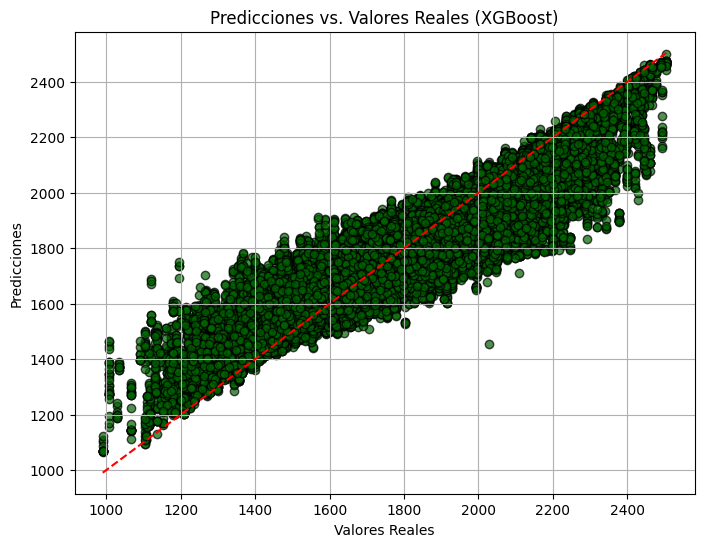

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que tienes 'y_test' y 'y_pred_xgb' para el modelo XGBoost
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_final, color='darkgreen', edgecolors='k', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Línea diagonal
plt.title('Predicciones vs. Valores Reales (XGBoost)')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)
plt.show()


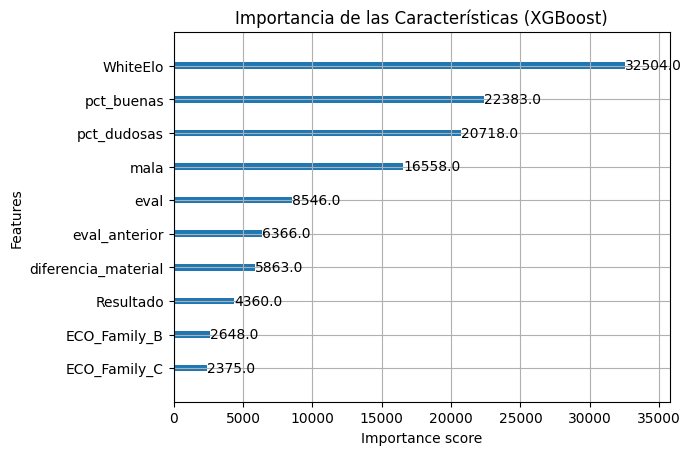

In [36]:
import xgboost as xgb

# Suponiendo que el modelo XGBoost está entrenado y almacenado en 'model_xgb'
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.title('Importancia de las Características (XGBoost)')
plt.show()


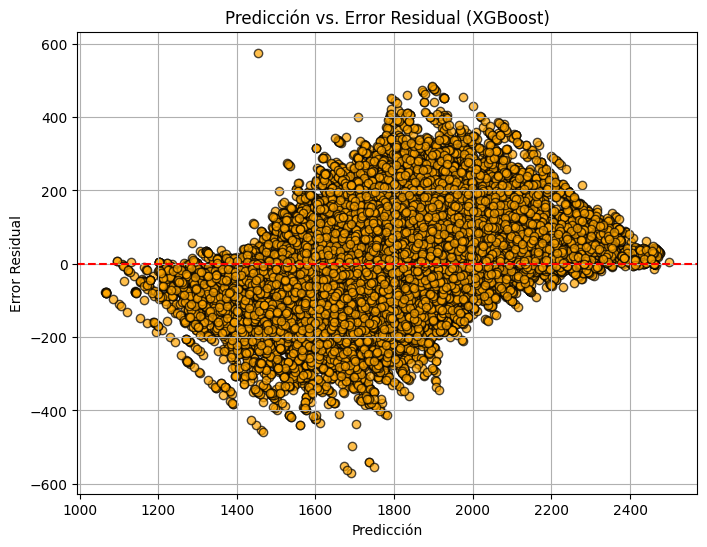

In [40]:
# Calcular residuos
residuos_xgb = y_test - y_pred_final

plt.figure(figsize=(8, 6))
plt.scatter(y_pred_final, residuos_xgb, color='orange', edgecolors='k', alpha=0.7)
plt.axhline(0, color='red', linestyle='--')  # Línea horizontal en 0 para referencia
plt.title('Predicción vs. Error Residual (XGBoost)')
plt.xlabel('Predicción')
plt.ylabel('Error Residual')
plt.grid(True)
plt.show()


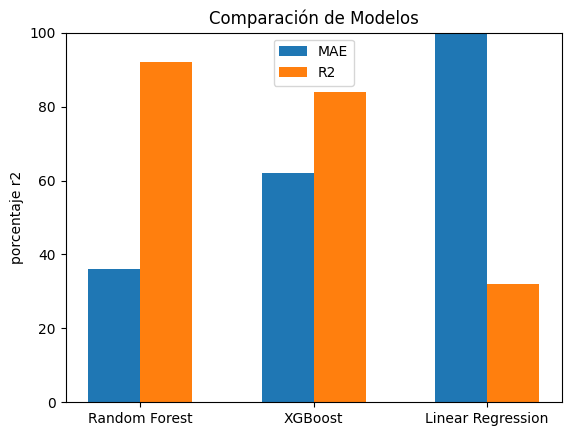

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Ejemplo de datos
models = ['Random Forest', 'XGBoost', 'Linear Regression']
mae = [36, 62, 132]  # Error absoluto medio
r2score = [92, 84, 32]  # Raíz del error cuadrático medio

# Crear gráfico de barras
x = np.arange(len(models))
width = 0.3

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, mae, width, label='MAE')
bars2 = ax.bar(x + width/2, r2score, width, label='R2')

ax.set_ylabel('porcentaje r2')
ax.set_title('Comparación de Modelos')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Limitar el eje vertical a 100

ax.legend()

plt.show()
